In [62]:
import pandas as pd
import torch
import json
import os
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy import stats
from matplotlib.ticker import ScalarFormatter
from sklearn.metrics import f1_score,accuracy_score,recall_score
import traceback



import warnings
warnings.filterwarnings('ignore')

In [63]:
from aif360.sklearn import metrics
from sklearn.metrics import confusion_matrix

In [64]:
path = 'data/datasets/compas/'
compas_df = pd.read_csv(path+'test.csv',header=None)
compas_df.columns = ['juv_fel_count', 'juv_misd_count', 'juv_other_count', 'priors_count',
                'age', 
                'c_charge_degree', 
                'c_charge_desc',
                'age_cat',
                'sex', 'race',  'is_recid']
compas_df['ground_truth'] = pd.Categorical(compas_df['is_recid']).codes
compas_df.drop('is_recid',axis=1,inplace=True)

In [65]:
for file in os.listdir(path+'preds/'):
    # check only text files
    if file.endswith('.json'):
        f = open(path+'preds/'+file)
        items = json.load(f)
        f.close()
        cname = file.split('.')[0]
        compas_df[cname]=items
    if file.endswith('.pt'):
        items = torch.load(path+'preds/'+file)
        cname = file.split('.')[0]
        compas_df[cname]=[int(i) for i in items.flatten().cpu().numpy()]

In [66]:
compas_df

,juv_fel_count,juv_misd_count,juv_other_count,priors_count,age,c_charge_degree,c_charge_desc,age_cat,sex,race,...,gsr_pred_TruePositiveRateParity,gsr_pred_FalsePositiveRateParity,gsr_pred_ErrorRateParity,caleq_pred_fnr,caleq_pred_fpr,caleq_pred_weighted,rocv_pred_statistical_parity,rocv_pred_average_odds,rocv_pred_equal_opportunity,DRO_pred
0,0,0,0,0,62,F,False Imprisonment,Greater than 45,Male,White,...,0,0,0,1,0,0,0,0,0,0
1,0,0,0,1,28,M,Battery,25 - 45,Male,Black,...,0,0,0,1,0,0,0,0,0,0
2,0,0,0,8,57,M,DUI Level 0.15 Or Minor In Veh,Greater than 45,Male,Black,...,0,0,0,1,0,0,0,0,0,0
3,0,1,0,1,19,F,arrest case no charge,Less than 25,Male,Black,...,1,1,1,1,1,1,1,1,1,1
4,0,0,0,0,37,M,Battery,25 - 45,Female,Other,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2160,0,0,0,3,30,F,Driving While License Revoked,25 - 45,Male,Black,...,0,0,1,1,1,0,1,0,1,1
2161,0,0,0,1,63,M,Battery,Greater than 45,Male,White,...,0,0,0,1,0,0,0,0,0,0
2162,0,0,0,1,25,M,Aide/Abet Prostitution Lewdness,25 - 45,Female,White,...,0,1,0,0,0,0,1,0,1,0
2163,0,0,0,0,21,M,Battery,Less than 25,Male,Other,...,0,0,0,1,1,0,0,0,1,0


In [67]:
def tprdiff(ground_truth, out_pred):
    out_m = out_pred.loc['Male']
    out_f = out_pred.loc['Female']
    ground_m = ground_truth.loc['Male']
    ground_f = ground_truth.loc['Female']
    tnm, fpm, fnm, tpm = confusion_matrix(ground_m, out_m).ravel()
    tnf, fpf, fnf, tpf = confusion_matrix(ground_f, out_f).ravel()
    TPD = (tpm/len(out_m)) - (tpf/len(out_f))
    FPD = (fpm/len(out_m)) - (fpf/len(out_f))
    FND = (fnm/len(out_m)) - (fnf/len(out_f))
    return TPD,FPD,FND

In [68]:
# Make groups

allm = ['baseline_pred', 'adv_rew_pred', 'adv_deb_pred',
       'lfr_pred', 'egr_pred_DemographicParity', 'egr_pred_EqualizedOdds',
       'egr_pred_TruePositiveRateParity', 'egr_pred_FalsePositiveRateParity',
       'egr_pred_ErrorRateParity', 'gsr_pred_DemographicParity',
       'gsr_pred_EqualizedOdds', 'gsr_pred_TruePositiveRateParity',
       'gsr_pred_FalsePositiveRateParity', 'gsr_pred_ErrorRateParity',
       'caleq_pred_fnr', 'caleq_pred_fpr', 'caleq_pred_weighted',
       'rocv_pred_statistical_parity', 'rocv_pred_average_odds',
       'rocv_pred_equal_opportunity', 'DRO_pred', 'ARL_pred']

metgroups = [

('statistical_parity_difference', ['baseline_pred', 'adv_rew_pred', 'adv_deb_pred',
       'lfr_pred', 'egr_pred_DemographicParity', 'gsr_pred_DemographicParity',
       'rocv_pred_statistical_parity', 'DRO_pred', 'ARL_pred']),

('true_positive_rate_difference', ['baseline_pred', 'adv_rew_pred', 'adv_deb_pred',
       'lfr_pred', 
       'egr_pred_TruePositiveRateParity', 'gsr_pred_TruePositiveRateParity', 'DRO_pred', 'ARL_pred']),


('false_positive_rate_difference',['baseline_pred', 'adv_rew_pred', 'adv_deb_pred',
       'lfr_pred', 'egr_pred_FalsePositiveRateParity',
       'gsr_pred_FalsePositiveRateParity', 'caleq_pred_fpr', 'DRO_pred', 'ARL_pred']),

('false_negative_rate_difference', ['baseline_pred', 'adv_rew_pred', 'adv_deb_pred','lfr_pred','caleq_pred_fnr','DRO_pred', 'ARL_pred']),

('disparate_impact_ratio', allm),

('equal_opportunity_difference', ['baseline_pred', 'adv_rew_pred', 'adv_deb_pred',
       'lfr_pred', 'rocv_pred_equal_opportunity', 'DRO_pred', 'ARL_pred']),

('average_odds_difference', ['baseline_pred', 'adv_rew_pred', 'adv_deb_pred',
       'lfr_pred',  'egr_pred_EqualizedOdds', 'caleq_pred_weighted',
       'gsr_pred_EqualizedOdds', 'rocv_pred_average_odds','DRO_pred', 'ARL_pred']),

('kl_divergence',allm),

# ('smoothed_edf', allm),

# ('df_bias_amplification',allm),

('theil_index',allm), #theil index
    
('accuracy', allm),
    
('f1_score', allm)

]
# (conditional_demographic_disparity, allm)




In [69]:
def getresultsdict(adult_df):
    ground_truth = adult_df['ground_truth']
    ground_truth.index = adult_df['sex']

    results = {}

    for item in metgroups:

        if item[0] == 'statistical_parity_difference':
            if 'Statistical Parity Difference' not in results:
                results['Statistical Parity Difference'] = {}
            for out in item[1]:
                try: 
                    out_pred = adult_df[out]
                    out_pred.index = adult_df['sex'] 
    #                 print(out, 'statistical_parity_difference: ', metrics.statistical_parity_difference(out_pred,prot_attr='sex',priv_group='Male'))
                    results['Statistical Parity Difference'][out] = metrics.statistical_parity_difference(out_pred,prot_attr='sex',priv_group='Male')
                except:
                    results['Statistical Parity Difference'][out] = None


        if item[0] == 'true_positive_rate_difference':
            if 'True Positive Rate Difference' not in results:
                results['True Positive Rate Difference'] = {}
            for out in item[1]:
                try: 
                    out_pred = adult_df[out]
                    out_pred.index = adult_df['sex'] 
                    TPD,FPD,FND = tprdiff(ground_truth, out_pred)
    #                 print(out, 'true_positive_rate_difference: ', TPD)
                    results['True Positive Rate Difference'][out] = TPD
                except:
                    results['True Positive Rate Difference'][out] = None

        if item[0] == 'false_positive_rate_difference':
            if 'False Positive Rate Difference' not in results:
                results['False Positive Rate Difference'] = {}
            for out in item[1]:
                try: 
                    out_pred = adult_df[out]
                    out_pred.index = adult_df['sex'] 
                    TPD,FPD,FND = tprdiff(ground_truth, out_pred) 
    #                 print(out, 'false_positive_rate_difference: ', FPD)
                    results['False Positive Rate Difference'][out] = FPD
                except:
                    results['False Positive Rate Difference'][out] = None

        if item[0] == 'false_negative_rate_difference':
            if 'False Negative Rate Difference' not in results:
                results['False Negative Rate Difference'] = {}
            for out in item[1]:
                try: 
                    out_pred = adult_df[out]
                    out_pred.index = adult_df['sex'] 
                    TPD,FPD,FND = tprdiff(ground_truth, out_pred)
    #                 print(out, 'false_negative_rate_difference: ', FND)
                    results['False Negative Rate Difference'][out] = FND
                except:
                    results['False Negative Rate Difference'][out] = None

        if item[0] == 'disparate_impact_ratio':
            if 'Disparate Impact Ratio' not in results:
                results['Disparate Impact Ratio'] = {}
            for out in item[1]:
                try: 
                    out_pred = adult_df[out]
                    out_pred.index = adult_df['sex']
    #                 print(out, 'disparate_impact_ratio: ', metrics.disparate_impact_ratio(ground_truth,out_pred,prot_attr='sex',priv_group='Male'))
                    results['Disparate Impact Ratio'][out] = metrics.disparate_impact_ratio(ground_truth,out_pred,prot_attr='sex',priv_group='Male')
                except:
                    results['Disparate Impact Ratio'][out] = None

        if item[0] == 'equal_opportunity_difference':
            if 'Equal Opportunity Difference' not in results:
                results['Equal Opportunity Difference'] = {}
            for out in item[1]:
                try: 
                    out_pred = adult_df[out]
                    out_pred.index = adult_df['sex']
    #                 print(out, 'equal_opportunity_difference: ', metrics.equal_opportunity_difference(ground_truth,out_pred,prot_attr='sex'))
                    results['Equal Opportunity Difference'][out] = metrics.equal_opportunity_difference(ground_truth,out_pred,prot_attr='sex')            
                except:
                    results['Equal Opportunity Difference'][out] = None

        if item[0] == 'average_odds_difference':
            if 'Average Odds Difference' not in results:
                results['Average Odds Difference'] = {}
            for out in item[1]:
                try: 
                    out_pred = adult_df[out]
                    out_pred.index = adult_df['sex']
    #                 print(out, 'average_odds_difference: ', metrics.average_odds_difference(ground_truth,out_pred,prot_attr='sex'))
                    results['Average Odds Difference'][out] = metrics.average_odds_difference(ground_truth,out_pred,prot_attr='sex')            
                except:
                    results['Average Odds Difference'][out] = None            

            if 'kl_divergence' not in results:
                results['KL Divergence'] = {}
            for out in item[1]:
                try: 
                    out_pred = adult_df[out]
                    out_pred.index = adult_df['sex']
    #                 print(out, 'kl_divergence: ', metrics.kl_divergence(ground_truth,out_pred,prot_attr='sex',priv_group='Male'))
                    results['KL Divergence'][out] = metrics.kl_divergence(ground_truth,out_pred,prot_attr='sex',priv_group='Male')       
                except:
                    results['KL Divergence'][out] = None

#         if item[0] == 'smoothed_edf':
#             if 'Smoothed Edf' not in results:
#                 results['Smoothed Edf'] = {}
#             for out in item[1]:
#                 try: 
#                     out_pred = adult_df[out]
#                     out_pred.index = adult_df['sex']
#     #                 print(out, 'smoothed_edf: ', metrics.smoothed_edf(ground_truth,out_pred,prot_attr='sex'))
#                     results['Smoothed Edf'][out] = metrics.smoothed_edf(ground_truth,out_pred,prot_attr='sex')    
#                 except:
#                     pass

#         if item[0] == 'df_bias_amplification':
#             if 'Df Bias Amplification' not in results:
#                 results['Df Bias Amplification'] = {}
#             for out in item[1]:
#                 try: 
#                     out_pred = adult_df[out]
#                     out_pred.index = adult_df['sex']
#     #                 print(out, 'df_bias_amplification: ', metrics.df_bias_amplification(ground_truth,out_pred,prot_attr='sex'))
#                     results['Df Bias Amplification'][out] = metrics.df_bias_amplification(ground_truth,out_pred,prot_attr='sex')
#                 except:
#                     pass

        if item[0] == 'theil_index':
            if 'Theil Index' not in results:
                results['Theil Index'] = {}
            for out in item[1]:
                try: 
                    out_pred = adult_df[out]
                    out_pred.index = adult_df['sex']
    #                 print(out, 'between_group_generalized_entropy_error: ', metrics.between_group_generalized_entropy_error(ground_truth,out_pred,prot_attr='sex',priv_group='Male'))
                    results['Theil Index'][out] = metrics.theil_index(out_pred)
                    if results['Theil Index'][out] == 0:
                        results['Theil Index'][out] = None
                except:
                    results['Theil Index'][out] = None
                
        if item[0] == 'accuracy':
            if 'Accuracy' not in results:
                results['Accuracy'] = {}
            for out in item[1]:
                try:
                    out_pred = adult_df[out]
                    out_pred.index = adult_df['sex']
                    results['Accuracy'][out] = accuracy_score(list(ground_truth), list(out_pred))
                except:
                    results['Accuracy'][out] = None
                
        if item[0] == 'f1_score':
            if 'F1 Score' not in results:
                results['F1 Score'] = {}
            for out in item[1]:
                try: 
                    out_pred = adult_df[out]
                    out_pred.index = adult_df['sex']
                    results['F1 Score'][out] = f1_score(list(ground_truth), list(out_pred))
                except:
                    results['F1 Score'][out] = None
    
    return results
            

In [70]:
namedic = {}
namedic['baseline_pred'] = 'Baseline LogReg (No Fairness Intervention)'
namedic['caleq_pred'] = 'Calibrated Equalized Odds'
namedic['rocv_pred'] = 'Reject Option Classifier'
namedic['adv_rew_pred'] = 'Sample Reweighting'
namedic['lfr_pred'] = 'Learned Fair Representation'
namedic['adv_deb_pred'] = 'Adversarial Debiasing'
namedic['egr_pred'] = 'Exponentiated Gradient Reduction'
namedic['gsr_pred'] = 'Gridsearch Reduction'
namedic['DRO_pred'] = 'Distributed Robust Optimization'
namedic['ARL_pred'] = 'Adversarially Reweighted Learning'


namedic2 = {}
namedic2['baseline_pred'] = 'BASE'
namedic2['caleq_pred'] = 'CALEQ'
namedic2['rocv_pred'] = 'ROC'
namedic2['adv_rew_pred'] = 'SREW'
namedic2['lfr_pred'] = 'LFR'
namedic2['adv_deb_pred'] = 'ADDEB'
namedic2['egr_pred'] = 'EGR'
namedic2['gsr_pred'] = 'GSR'
namedic2['DRO_pred'] = 'DRO'
namedic2['ARL_pred'] = 'ADREW'
def algnames(name):
    return namedic2[name]

In [71]:
# 2 line plots per metric - synthetic
# histograms for case studies 

def get_df(results, percentage, version):

    yeslist = ['baseline_pred', 'caleq_pred_fnr', 'caleq_pred_fpr', 'caleq_pred_weighted',
           'rocv_pred_statistical_parity', 'rocv_pred_average_odds',
           'rocv_pred_equal_opportunity'] 

    midlist = ['adv_rew_pred', 'lfr_pred', 'adv_deb_pred',
           'egr_pred_DemographicParity', 'egr_pred_EqualizedOdds',
           'egr_pred_TruePositiveRateParity', 'egr_pred_FalsePositiveRateParity',
           'egr_pred_ErrorRateParity', 'gsr_pred_DemographicParity',
           'gsr_pred_EqualizedOdds', 'gsr_pred_TruePositiveRateParity',
           'gsr_pred_FalsePositiveRateParity', 'gsr_pred_ErrorRateParity'] 

    nolist = ['DRO_pred', 'ARL_pred'] 

    DF_list = []

    for metric in results:
        algset = {}
        for alg in results[metric]:
            entry = {}
            entry['metric'] = metric
            if len(alg.split('_pred'))>0:
                if alg.split('_pred')[0]+'_pred' not in algset:
                    algset[alg.split('_pred')[0]+'_pred']=[]
                if results[metric][alg]:    
                    algset[alg.split('_pred')[0]+'_pred'].append(results[metric][alg])
                entry['algorithm'] = algnames(alg.split('_pred')[0]+'_pred')
                entry['value'] = np.mean(algset[alg.split('_pred')[0]+'_pred'])
            else:
                entry['algorithm'] = algnames(alg)
                entry['value'] = results[metric][alg]
            if alg in yeslist:
                entry['Needs Attributes'] = 'Both during Training and Testing'
            if alg in midlist:
                entry['Needs Attributes'] = 'During Training only'
            if alg in nolist:
                entry['Needs Attributes'] = 'Does not require protected attributes'
            DF_list.append(entry)

    resultsdf = pd.DataFrame(DF_list)
    resultsdf = resultsdf.drop_duplicates(subset=['metric', 'algorithm'], keep='last')
    
    resultsdf['percentage'] = percentage
    resultsdf['version'] = version

    df_temps = []
    for group, df_group in resultsdf.groupby('metric'):
        df_group['pct'] = 100 * (1 - df_group.iloc[0].value / df_group.value)
        df_group['diff'] = df_group.value - df_group.iloc[0].value
        df_temps.append(df_group)
        
    return pd.concat(df_temps)


In [72]:
def get_stability(tdf):
    tdf = groupsizedf[groupsizedf['metric']=='Average Odds Difference']
    tdf = tdf.groupby(['algorithm','percentage']).agg('std').reset_index().fillna(0)
    tdf = tdf.groupby(['algorithm']).agg("mean").reset_index()
    tdf = tdf[['algorithm','value']]
    return dict(zip(tdf['algorithm'],tdf['value']))

In [73]:
# sorter = ['Baseline LogReg (No Fairness Intervention)',
#  'Calibrated Equalized Odds',
#  'Reject Option Classifier',
#  'Sample Reweighting',
#  'Learned Fair Representation',
#  'Adversarial Debiasing',
#  'Exponentiated Gradient Reduction',
#  'Gridsearch Reduction',
#  'Distributed Robust Optimization',
#  'Adversarially Reweighted Learning']
sorter = list(namedic2.values())

In [74]:
results = getresultsdict(compas_df)
df_temps = get_df(results,0,0)
df_temps.sort_values(by="algorithm", key=lambda column: column.map(lambda e: sorter.index(e)), inplace=True)

In [75]:
df_temps

,metric,algorithm,value,Needs Attributes,percentage,version,pct,diff
104,Accuracy,BASE,0.676674,Both during Training and Testing,0,0,0.000000,0.000000
26,False Negative Rate Difference,BASE,-0.061029,Both during Training and Testing,0,0,0.000000,0.000000
72,KL Divergence,BASE,0.192267,Both during Training and Testing,0,0,0.000000,0.000000
126,F1 Score,BASE,0.646465,Both during Training and Testing,0,0,0.000000,0.000000
55,Equal Opportunity Difference,BASE,0.632411,Both during Training and Testing,0,0,0.000000,0.000000
...,...,...,...,...,...,...,...,...
81,KL Divergence,ADREW,0.016771,Does not require protected attributes,0,0,-1046.432444,-0.175496
54,Disparate Impact Ratio,ADREW,0.784795,Does not require protected attributes,0,0,44.669402,0.350563
32,False Negative Rate Difference,ADREW,0.007146,Does not require protected attributes,0,0,953.987241,0.068175
103,Theil Index,ADREW,0.945584,Does not require protected attributes,0,0,14.873394,0.140640


Accuracy


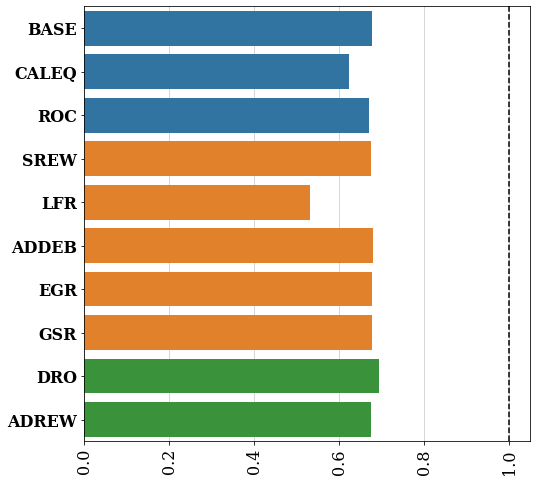

Average Odds Difference


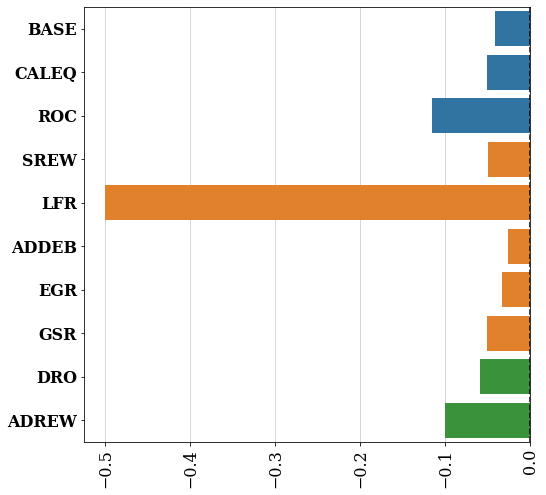

Disparate Impact Ratio


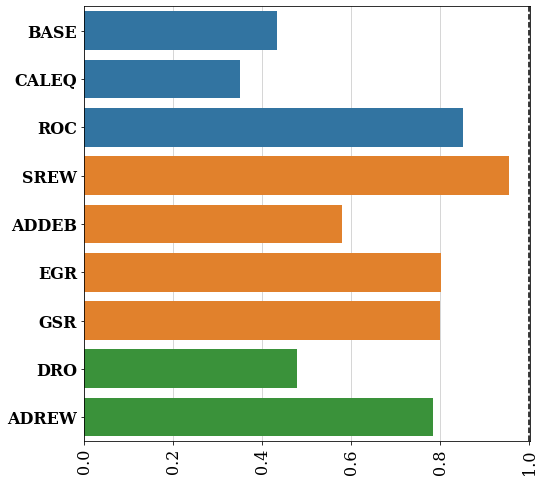

Equal Opportunity Difference


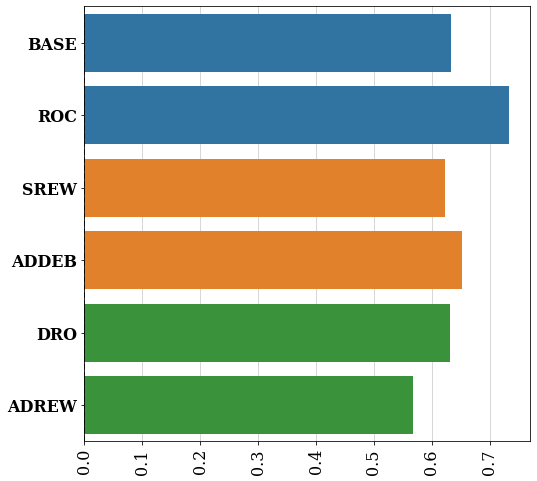

F1 Score


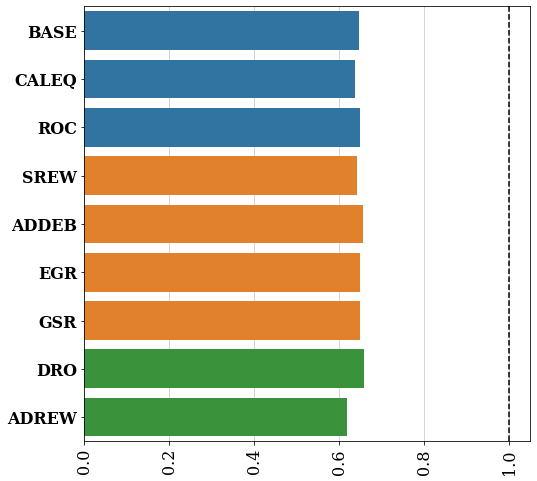

False Negative Rate Difference


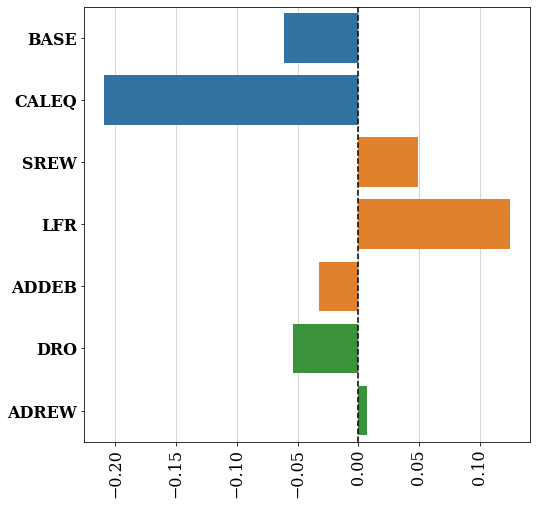

False Positive Rate Difference


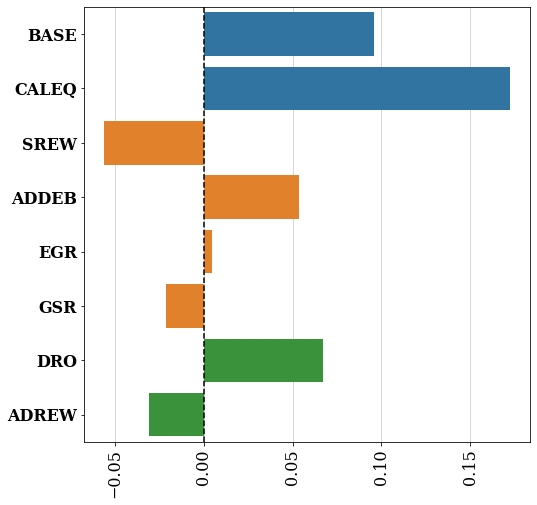

KL Divergence


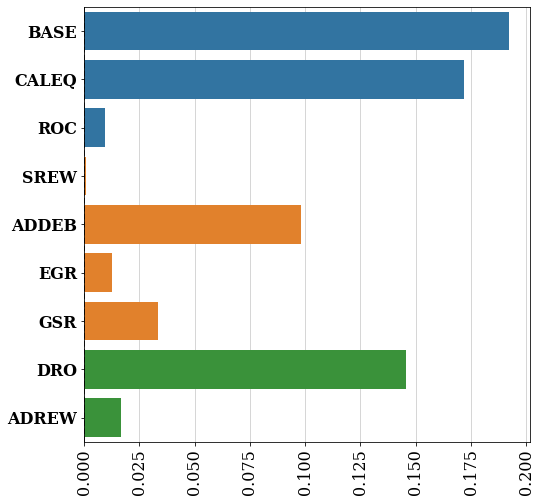

Statistical Parity Difference


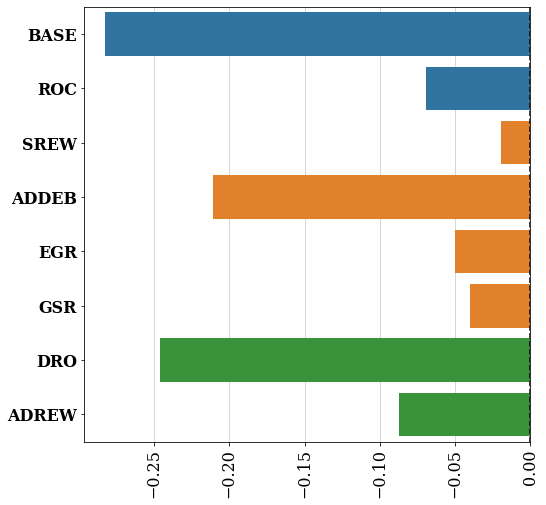

Theil Index


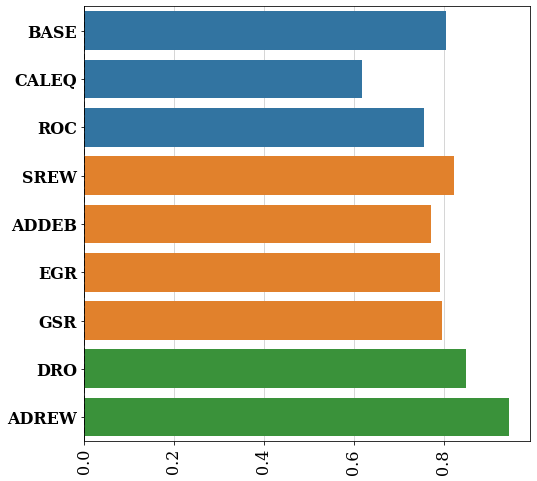

True Positive Rate Difference


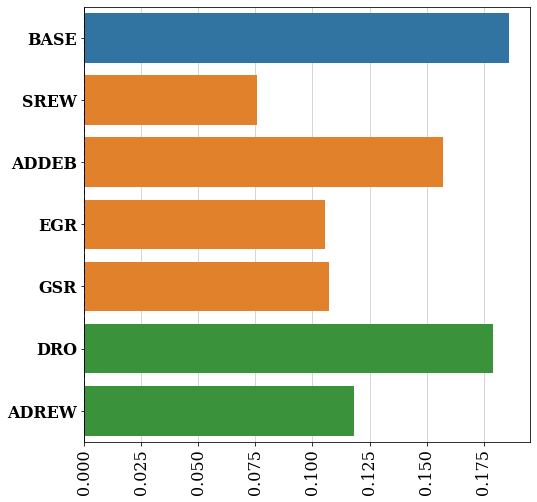

In [76]:
mpl.rcParams['figure.figsize'] = (8, 8)
plt.rcParams["font.family"] = 'DejaVu Serif'
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.alpha'] = 1
plt.rcParams['grid.color'] = "#cccccc"
plt.rcParams["pdf.fonttype"] = 42
plt.rcParams["ps.fonttype"] = 42


gdic = {}

for group, df_group in df_temps.groupby('metric'):
    hue_order = ['Both during Training and Testing', 'During Training only', 'Does not require protected attributes']
    df_group.replace([np.inf, -np.inf], np.nan, inplace=True)
    df_group = df_group.dropna()
    ax = sns.barplot(data=df_group, y='algorithm', x='value', hue='Needs Attributes',dodge=False,hue_order=hue_order)
    
#     plt.title(group,fontsize=18,weight='bold')
    
    ax.xaxis.grid(True,which='both')
    ax.yaxis.grid(False,which='both')
    
    if group in ['F1 Score', 'Accuracy','Disparate Impact Ratio']:
        plt.axvline(x=1,linestyle ='--', color='black')
    else:
        plt.axvline(x=0,linestyle ='--', color = 'black')


    ax.set_facecolor('white')
    ax.tick_params(axis='y', which='both',labelsize=16)
    ax.tick_params(axis='x', which='both',labelsize=16)

    ax.get_legend().remove()
    ax.set_axisbelow(True)
    plt.xlabel(None)
    plt.ylabel(None)
#     plt.xlabel(group)
    plt.xticks(rotation = 90) 
    plt.yticks(weight='bold')
    
#     for spine in ('left','right'): # 'bottom', 'left'): 
#         plt.gca().spines[spine].set_visible(False)

#     plt.xscale("symlog")
    print(group)
    plt.gca().xaxis.set_major_formatter(ScalarFormatter())
    plt.savefig('Plots/compas_casestudy__'+group+'.pdf', pad_inches = 0,bbox_inches = "tight")

    plt.show()